# Regularization (Ridge Regression) and Cross-validation



In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%load_ext autoreload
%autoreload 2
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
sns.set_style("white")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data
We are going to use an advertisement dataset. The task is to figure out how different means of advertisement influence the amount of sales of a product.
    
Let's load the data with Pandas!

In [3]:
# data loading
ad_df = pd.read_csv('Advertising.csv')
# view the first 5 rows 
ad_df.head()

,id,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


### Fit a linear regression
Let's use TV and Radio advertisment as features to predict the sales.


In [4]:
# making the data matrix and output
X = np.array(ad_df[["TV", "Radio"]])
y = np.array(ad_df["Sales"])
# check their dimensions
X.shape, y.shape

((200, 2), (200,))

In [5]:
# fit a linear regression model and check out the coefficients
LR = LinearRegression(fit_intercept=True)
LR.fit(X, y)
print("params: ", LR.coef_)
print("constant: ", LR.intercept_)
print("R^2 score: ", LR.score(X, y))

params:  [0.04575482 0.18799423]
constant:  2.9210999124051362
R^2 score:  0.8971942610828956


In [6]:
# make some predictions
print("TV: ", 200, "Radio: ", 50, "Sales: ", LR.predict(np.array([200, 50]).reshape(-1,2)))
print("TV: ", 200, "Radio: ", 30, "Sales: ", LR.predict(np.array([200, 30]).reshape(-1,2)))

TV:  200 Radio:  50 Sales:  [21.47177426]
TV:  200 Radio:  30 Sales:  [17.71188973]


### Using polynomial features (polynomial combination of features)
Sometimes the data cannot be explained by just a linear model and using a linear model yields a high error. In these cases we can add polynomial features to the data which is equivalent to fitting polynomial functions on the data points.

In [8]:
from sklearn.preprocessing import PolynomialFeatures
# use polynomial features (nonlinear model)
poly = PolynomialFeatures(2)
X = np.array(ad_df[["TV", "Radio"]])
y = np.array(ad_df["Sales"])
X_poly = poly.fit_transform(X)

In [9]:
X_poly.shape

(200, 6)

In [10]:
LR = LinearRegression(fit_intercept=False) # we don't need fit intercept sice polynomial features function adds a column of ones to the data 
LR.fit(X_poly, y)
print("params: ", LR.coef_)
print("R^2 score: ", LR.score(X_poly, y))

params:  [ 5.19444187e+00  5.09930683e-02  2.65400299e-02 -1.09816273e-04
  1.07462080e-03  1.86076136e-04]
R^2 score:  0.9860391010783739


### Training/Test split and Overfitting

The standard practice in Machine Learning is to keep the test data out of the model training and try to evaluate the model's performance on the unseen data in the test set.

Now let's see the effect of adding more polynomial features. Adding too many of these features will result in complex models that may cause overfitting. We can check this by plotting curves of the training and the test errors.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [12]:
# let's now use 1 feature from the data, namely TV, to predict the Sales
X = np.array(ad_df[["TV"]])
y = np.array(ad_df["Sales"])

Text(0, 0.5, 'error')

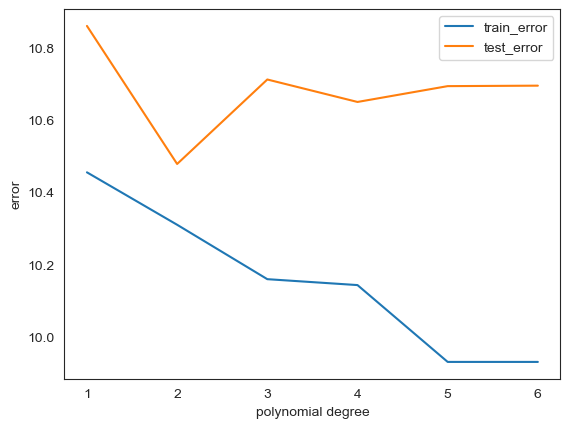

In [13]:
train_err = []
test_err = []
# fit models using polynomial features of orders between 1 and 6
# higher order polynomials have a higher model complexity 
for f in range(1,7):
    poly = PolynomialFeatures(f)
    X_poly = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=1)
    LR = LinearRegression(fit_intercept=False)
    LR.fit(X_train, y_train)
    train_err.append(mean_squared_error(y_train, LR.predict(X_train)))
    test_err.append(mean_squared_error(y_test, LR.predict(X_test)))
# plot the training and test errors for the different models used    
plt.plot(range(1,7), train_err, label="train_error")
plt.plot(range(1,7), test_err, label="test_error")
plt.legend(fontsize=10)
plt.xlabel("polynomial degree")
plt.ylabel("error")

### Fit Ridge regression to avoid overfitting
To avoid overfitting we can penalize the norm of the weight vector to encourage simpler models. This is called regularization. We will use Ridge Regression (linear regression with L2 regularizer). By tuning the regularization parameter (the hyperparameter of the model that controls its complexity) $\alpha$ we can minimize the test error.

In [14]:
from sklearn.linear_model import Ridge
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=1)
test_err = []
for alpha in np.linspace(0.1, 1, num=10):
    ridge_regression = Ridge(alpha=alpha)
    ridge_regression.fit(X_train, y_train)
    test_err.append(mean_squared_error(y_test, ridge_regression.predict(X_test)))
    

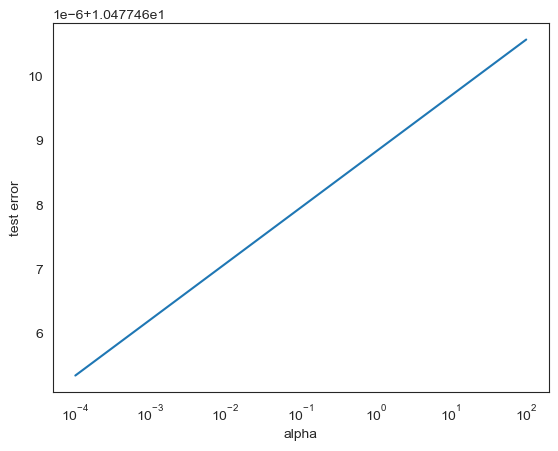

In [15]:
# plot the test error for different values of alpha
plt.semilogx(np.logspace(-4, 2, num=10), test_err)
plt.xlabel("alpha")
plt.ylabel("test error");

### Use cross validation to chose the best value for the regularization parameter
One way to do a hyperparameter tuning is through cross validation. Let's do a 5-fold CV. We need to make sure that our model has a good generalisation power and performs well on unseen data. For this purpose we can use the RidgeCV function.

In [14]:
# we use ridge regression with built in cross validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(fit_intercept=False, cv=5)
ridge.fit(X_train, y_train)

RidgeCV(cv=5, fit_intercept=False)

In [15]:
# print he fitted regression coefficients
ridge.coef_

array([ 6.02967461e+00,  6.62911088e-02, -5.93557717e-05])

In [16]:
# best regularizer
ridge.alpha_

0.1

In [17]:
# fit the model with the best selected alpha
ridge_best = Ridge(alpha=ridge.alpha_)
ridge_best.fit(X_train, y_train)
# compute the MSE on the test set
mean_squared_error(y_test, ridge_best.predict(X_test))

10.47746533459401